# Checkout statistical features of Spiral data 

## Import Data and Packages 

### Import necessary  packages

In [1]:
import cv2
import numpy as np
import os
from skimage.morphology import skeletonize
from skimage.morphology import closing, square
from PIL import Image
import matplotlib.pyplot as plt
from utils import thin_spiral_image_with_custom_cut, find_spiral_point, \
         trace_spiral, get_angle_dist2, angle_cont_func, plt_traced
from numba.typed import List
from time import perf_counter
from scipy import signal
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from scipy.ndimage import gaussian_filter1d

import random

### Path to the data


In [2]:
path = r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\data'

### Import all files from path

The path should be the absolute or relative path to the folder where all samples are stored. 

control1.tiff


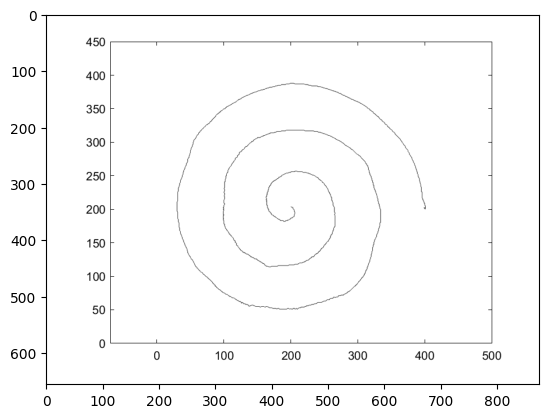

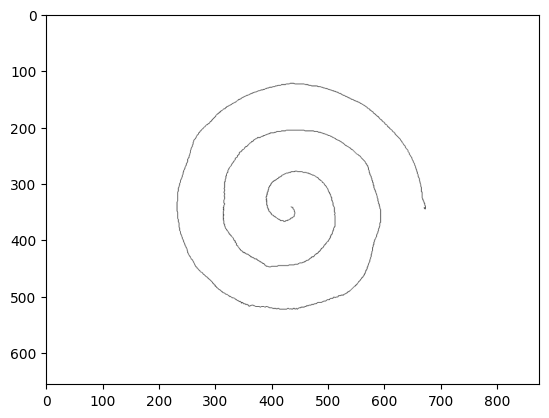

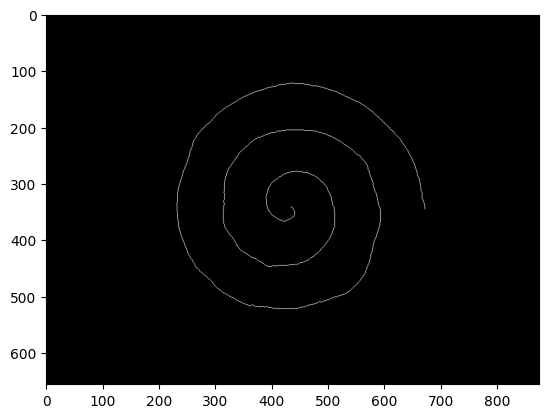

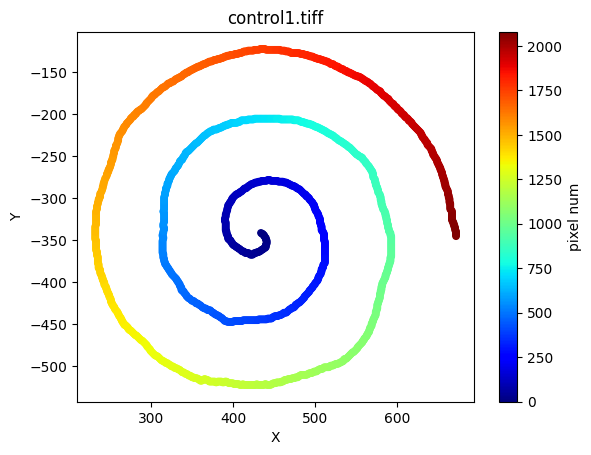

control10.tiff
control11.tiff
control12.tiff
control13.tiff
control14.tiff
control15.tiff
control2.tiff
control3.tiff
control4.tiff
control5.tiff
control6.tiff
control7.tiff
control8.tiff
control9.tiff
control_dynamic1.tiff
control_dynamic10.tiff
control_dynamic11.tiff
control_dynamic12.tiff
control_dynamic13.tiff
control_dynamic14.tiff
control_dynamic15.tiff
control_dynamic2.tiff
control_dynamic3.tiff
control_dynamic4.tiff
control_dynamic5.tiff
control_dynamic6.tiff
control_dynamic7.tiff
control_dynamic8.tiff
control_dynamic9.tiff
parkinson1.tiff
parkinson10.tiff
parkinson11.tiff
parkinson12.tiff
parkinson13.tiff
parkinson14.tiff
parkinson15.tiff
parkinson16.tiff
parkinson17.tiff
parkinson18.tiff
parkinson19.tiff
parkinson2.tiff
parkinson20.tiff
parkinson21.tiff
parkinson22.tiff
parkinson23.tiff
parkinson24.tiff
parkinson25.tiff
parkinson3.tiff
parkinson4.tiff
parkinson5.tiff
parkinson6.tiff
parkinson7.tiff
parkinson8.tiff
parkinson9.tiff
parkinson_dynamic1.tiff
parkinson_dynamic10.ti

In [3]:
names = []      # will contain all file names
trace_distances_all = []   # will contain all squared radius values of the spiral in polar coodinates
trace_angle_all = []       # will contain all phase values of the spiral in polar coodinates
all_paths = []             # will contain all x and y coordinates in cartesian coordinates
first = True    # to plot the first imported sample

for file_path in os.listdir(path):
    print(file_path)
    
    # make sure file is .tiff
    if not file_path[-5:] == '.tiff':
        print('file was skipped')
        continue
        
    # create skeleton
    img, cut_img_cropped, skeleton_img_cropped = thin_spiral_image_with_custom_cut(
        path + '\\' + file_path, 
        white_out=True,  
        field_of_interest=[(57, -81), (122, -91)])        

    # find center/start_point of the spiral
    spiral_start = find_spiral_point(skeleton_img_cropped, point=(0, 0), first=True, search_radius=200)
    
    # if no start point was found, spiral image will be plotted for future inspection
    if not spiral_start:
        print('not possible to extract')
        plt.imshow(img)
        plt.show()
        continue
        
    skeleton_img_trace = skeleton_img_cropped.copy()

    # follow the start point through the spiral
    trace_path = trace_spiral(skeleton_img_trace, spiral_start, search_radius=200)
    
    # turn the coordinates in angle and distance for a representation in polar coordinates
    trace_path_typed = List() 
    [trace_path_typed.append(i) for i in trace_path]
    trace_angle, trace_distances = get_angle_dist2(trace_path_typed)
    
    trace_angle_all.append(trace_angle)
    trace_distances_all.append(trace_distances)
    names.append(file_path)
    all_paths.append(trace_path)

    if first:
        plt.imshow(img,  'grey')
        plt.show()
        plt.imshow(cut_img_cropped,  'grey')
        plt.show()
        plt.imshow(skeleton_img_cropped, 'grey')
        plt.show()
        plt_traced(trace_path, file_path)
    first = False

## Squared Distance from the starting point 

From the squared distances from each spiral we get different smoothed results.

We extract the linear regression which converted back into cartesian coordinates together with the right phase represents a perfect spiral.
This gives us a template of the drawn spiral wihout knowing the exact template.

We save several gaussian smoothed results with different sigma values as well. 
Converted back into cartesian coordinates this corresponts to something in between the hand drawn one and the perfect one, containing the low frequent deviations from the hand drawn spiral but removed the high frequent "noise".
Different sigma values in the gaussian smoothing correspont to a different amount of high frequent signal that is filtered.
This results in a individual template for each spiral and enables us to have a deep insight in high frequent deviations from the template.

In [4]:
df = {}  # this dict will be used in the following to access all data, the key will be the file name of the spiral 

In [47]:

for d2, name in zip(trace_distances_all, names):
    df[name] = {}
    tmp = []
    
    color = 'red' if 'parkinson' in name else 'blue'
    for i in range(50):    
        filtered = gaussian_filter1d(d2, 1+6*i)
        tmp.append(np.std([l-m for l, m in zip(filtered, d2)]))
    df[name]['dist2_filtered'] = tmp

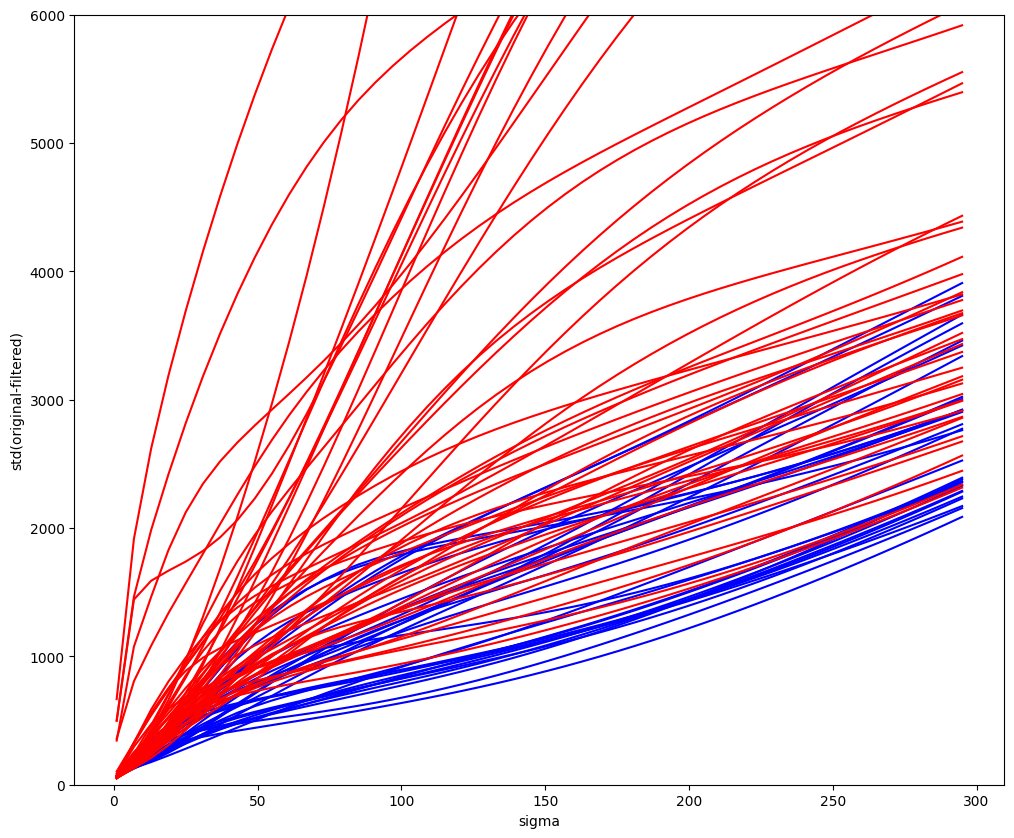

In [50]:
plt.figure(figsize=(12, 10))
for d2, name in zip(trace_distances_all, names):    
    color = 'red' if 'parkinson' in name else 'blue'
    
    tmp = df[name]['dist2_filtered']
    x = [i*6 + 1 for i in range(50)]
    plt.plot(x, tmp, c=color, linestyle='-', marker='', markersize=3)#, alpha=0.8)
plt.ylim((0,6000))
plt.xlabel('sigma')
plt.ylabel('std(original-filtered)')
#plt.xscale('log')
plt.title('')
plt.show()

## Squared Angle

The same thing as above is done to the (squared) Angle.

In [6]:
# convert the angle to a continuous curve
trace_angle_continuous = angle_cont_func(trace_angle_all)


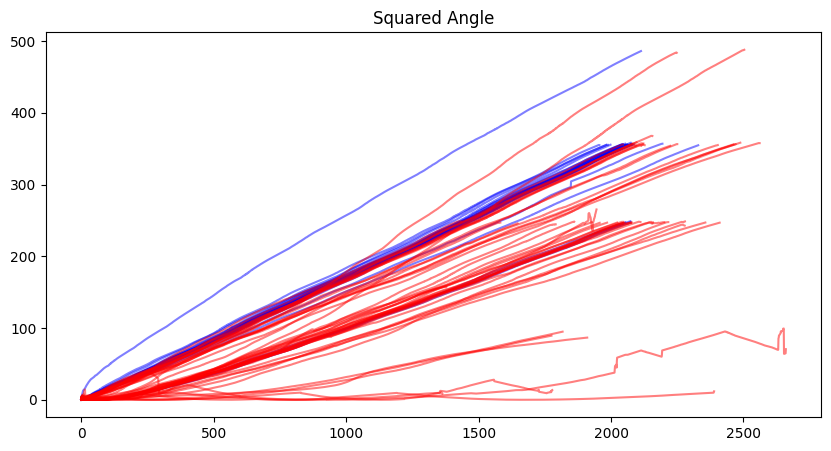

In [7]:
plt.figure(figsize=(10, 5))
for d2, name in zip(trace_angle_continuous, names):
    #df[name] = {}
    if True:#not 'dynamic' in name:
        d2 = [k*k for k in d2] 
        x = np.array([k for k in range(len(d2))]).reshape((-1, 1))
        reg = LinearRegression().fit(x, d2)
        pred = reg.predict(x)
        filtered = gaussian_filter1d(d2, 10)

        color = 'red' if 'parkinson' in name else 'blue'
        plt.plot(d2, c=color, alpha=0.5)
        #plt.plot(pred, c='k')
        #plt.plot(filtered, c='lightgrey')

        df[name]['ang2'] = d2
        df[name]['ang2_linreg'] = pred
        df[name]['ang2_filtered'] = filtered
        df[name]['slope'] = reg.coef_
        df[name]['inter'] = reg.intercept_
        
plt.title('Squared Angle')
plt.show()

## Feature selection

After feature selection as the best ones we found the distance deviation from different templates.

You wonder how we selected the features? And why we dropped the angle?
<b>Read our final paper! </b>

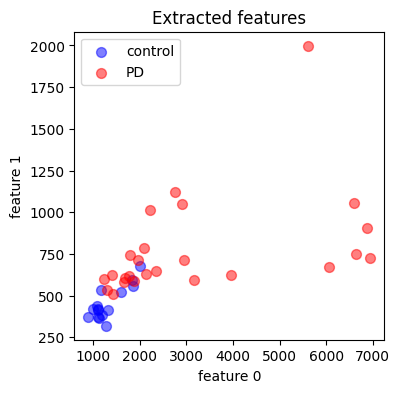

In [8]:

plt.figure(figsize=(4,4))
pd_lbl, c_lbl = False, False
class_0 = 'parkinson'
for name in df:
    if not 'dynamic' in name:
        sa, ea = 10, -10
        sd, ed = 10, -10
        c = 'red' if class_0 in name else 'blue'
        if class_0 in name and not pd_lbl:
            lbl = 'PD'
            pd_lbl = True
        elif not class_0 in name and not c_lbl:
            lbl = 'control'
            c_lbl = True
        else: 
            lbl = None
        x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
        y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
        
        t = name[-6:-5] if name[-7] in ['l', 'n', 'c'] else name[-7:-5]
        plt.scatter(x, y, c=c, s=50, alpha=0.5, label=lbl)
        #plt.text(x*1.01, y*1.01, t, fontsize=7)
plt.title('Extracted features')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()
plt.show()

## Classification

### Split Train and Test

This is a random split. 

Again, for a more meaningful and in detail Version, read our paper or contact us. 

In [9]:
X_train, X_test = [], []
y_train, y_test = [], []

for b in [True, False]:
    tmpX, tmpy = [], []
    df_rand = list(df.keys())
    random.seed(3141)
    random.shuffle(df_rand)
    for name in df_rand:
        if not 'dynamic' in name:
            if (('parkinson' in name) == b):
                sa, ea = 10, -10
                sd, ed = 10, -10
                lbl = 1 if 'parkinson' in name else 0
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                tmpX.append([x, y])
                tmpy.append(lbl)
    
    X_test.extend(tmpX[-len(tmpX)//3:])
    X_train.extend(tmpX[:-len(tmpX)//3])
    #print(tmpy)
    y_test.extend(tmpy[-len(tmpy)//3:])
    y_train.extend(tmpy[:-len(tmpy)//3])

### Classification

The classification is done with a Linear Discriminant Analysis.

The decision border is drawn in the scatter plot below.

In [10]:
clf = LogisticRegression()

clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

acc_test = 100 * (cm_test[0, 0] + cm_test[1, 1]) / sum(sum(cm_test))
print(f'test accuracy: {acc_test:.2f}%')

[[5 0]
 [0 9]]
test accuracy: 100.00%


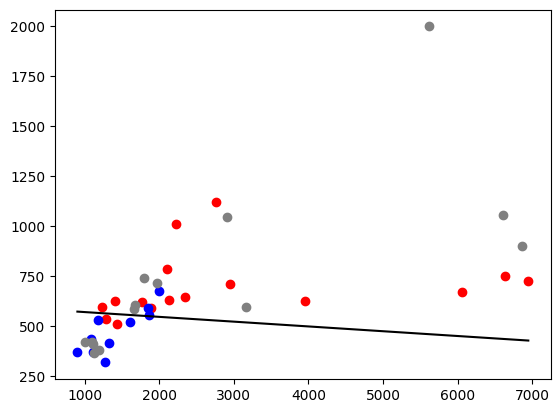

In [11]:
for X, y in zip(X_train, y_train):
    plt.scatter(X[0], X[1], c=['blue', 'red'][y])
for X in X_test:
    plt.scatter(X[0], X[1], c='grey')

plt.plot([min(np.array(X_train)[:, 0]), max(np.array(X_train)[:, 0])], [-(clf.intercept_ + min(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1], -(clf.intercept_ + max(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1]], 'k')

### k-fold cross validation with different random split seeds

Average Accuracy: 0.87225
Standard devatation Accuracy: 0.11050424200002461


(array([  3.,  24.,   0., 111.,   0., 205., 157.]),
 array([0.5       , 0.57142857, 0.64285714, 0.71428571, 0.78571429,
        0.85714286, 0.92857143, 1.        ]),
 <BarContainer object of 7 artists>)

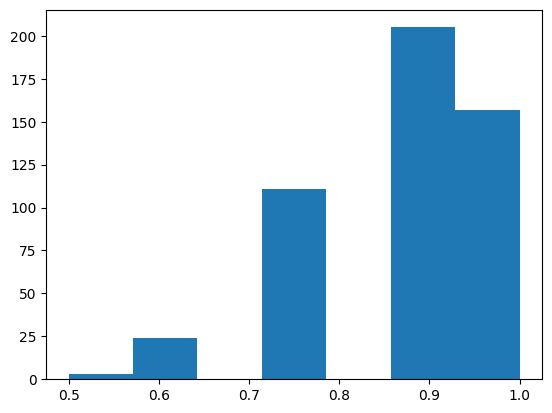

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

pd = []
healthy = []

for name in names:
    if not 'dynamic' in  name: 
        if 'parkinson' in name:
            pd.append(name)
        else:
             healthy.append(name)

X = np.array(pd + healthy)
Y = np.array([1] * len(pd) + [0] * len(healthy))


# Number of folds
k = 5

# List to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

model = LogisticRegression()


for seed in range(100):

    # Create k-fold cross-validation object
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)


    # Perform k-fold cross validation
    for train_index, test_index in skf.split(X, Y):    # Split data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        X_train_data = []
        X_test_data = []

        for name in X_train:
                    x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                    y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                    X_train_data.append([x, y])
        
        for name in X_test:
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                X_test_data.append([x, y])

        
        # Fit the model
        model.fit(X_train_data, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_data)
        y_pred_prob = model.predict_proba(X_test_data)

        # Calculate and store the results
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

# Calculate average accuracy across all folds and splits
average_accuracy = np.mean(accuracies)
average_std = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy}")
print(f"Standard devatation Accuracy: {average_std}")
plt.hist(accuracies, bins=7)

#### Example of ROC from one random split

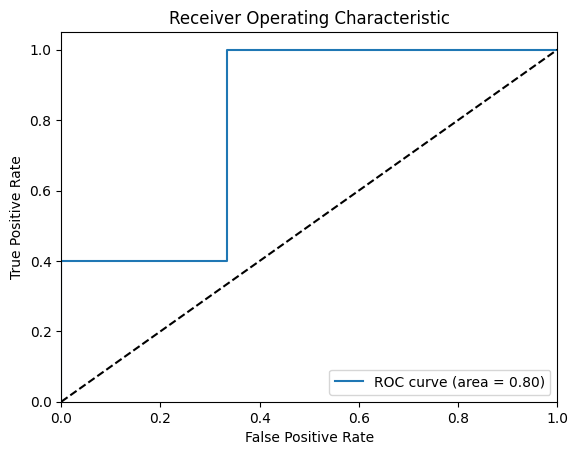

In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1]) # y_pred_prob is the probability of the positive class
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()